Reference https://github.com/trhgquan/MTH089/blob/dae5a8f8f7707aa9cac1df9f7b0011d4f7a741d7/practice/TREC-classification/code/deep-learning/BERT-based-classification.ipynb


In [1]:
!pip install transformers==4.25.1 datasets==2.8.0 accelerate==0.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.7 MB/s 
     |████████████████████████████████| 452 kB 61.9 MB/s 
     |████████████████████████████████| 191 kB 67.2 MB/s 
     |████████████████████████████████| 7.6 MB 61.3 MB/s 
     |████████████████████████████████| 182 kB 65.6 MB/s 
     |████████████████████████████████| 213 kB 59.9 MB/s 
     |████████████████████████████████| 132 kB 66.9 MB/s 
     |████████████████████████████████| 127 kB 52.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import os
import re
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing

from transformers import AutoTokenizer
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import torch
from torch.utils.checkpoint import checkpoint
import torch.nn as nn

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(0)

In [3]:
model_name = "distilbert-base-uncased"

## Prepare Data

### Get Data - And apply simple normalization

In [161]:
from datasets import load_dataset

train_dataset = load_dataset("trec", split='train')  
test_dataset = load_dataset("trec", split = "test")


# Let's make this imbalanced by removing a bunch of examples from class 0 and class 2

In [163]:
# filter() returns rows that match a specified condition: if probability > .8 and label is 0 or 2, then take it. 
train_dataset = train_dataset.filter(lambda x:  random.random() > 0.8 if (x["coarse_label"] in (0, 2)) else True)


  0%|          | 0/6 [00:00<?, ?ba/s]

In [204]:
print(train_dataset.features['coarse_label'].names)
print(train_dataset.features['coarse_label'])

['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']
ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None)


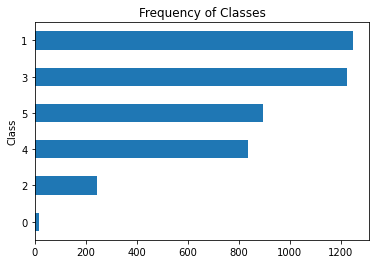

In [228]:
# import matplotlib.pyplot as plt
# train_dataset["coarse_label"].value_counts(ascending=True).plot.barh()
# plt.title("Frequency of Classes")
# plt.ylabel('Class')
# plt.show()  

# Print frequency of various classes: verify class imbalance

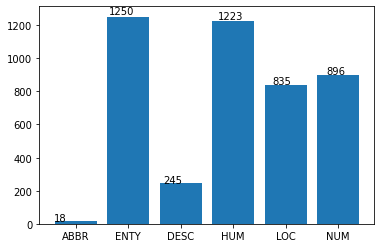

In [247]:
fig, ax = plt.subplots()
_, counts = np.unique(train_dataset["coarse_label"], return_counts=True)
ax.bar(train_dataset.features['coarse_label'].names, counts)
ax.set_xticks(train_dataset.features['coarse_label'].names)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.04, p.get_height() * 1.012))
plt.show()

In [164]:
train, dev = train_dataset.train_test_split(
    test_size = .2,
    seed = 42,
    stratify_by_column = "coarse_label"
).values()
     

In [165]:
test_dataset

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 500
})

In [166]:
print(dataset["train"].features["coarse_label"])
label_names = dataset["train"].features["coarse_label"].names
print(label_names)

ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None)
['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']


In [167]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": train,
    "dev": dev,
    "test": test_dataset
})

In [168]:
# Get tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 512

In [169]:
tokenizer(dataset['train'][0]["text"])


{'input_ids': [101, 2129, 2106, 1996, 4535, 1997, 2190, 2158, 2707, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [170]:
from collections import Counter
Counter(test_dataset['coarse_label'])

Counter({5: 113, 4: 81, 3: 65, 2: 138, 1: 94, 0: 9})

## Create tokenized dataset

In [171]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation = True)
tokenized_dataset = dataset.map(preprocess_function, batched = True, remove_columns = ["fine_label"])
tokenized_dataset = tokenized_dataset.rename_column("coarse_label", "labels")
tokenized_dataset


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 3573
    })
    dev: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 894
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [174]:
from collections import Counter
print(Counter(tokenized_dataset['train']['labels']))
print(Counter(tokenized_dataset['dev']['labels']))
print(Counter(tokenized_dataset['test']['labels']))


Counter({1: 1000, 3: 978, 5: 717, 4: 668, 2: 196, 0: 14})
Counter({1: 250, 3: 245, 5: 179, 4: 167, 2: 49, 0: 4})
Counter({2: 138, 5: 113, 1: 94, 4: 81, 3: 65, 0: 9})


### Create a label column and input column
* Input is going to be [discourse_text + essay_text]
* Label is going to be numericalised version of the three classes

## Define Dynamic padding

In [175]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Define model

In [176]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

## Define Training Arguments

In [177]:
def trainaug(runname):
    training_args = TrainingArguments(
        run_name=runname,
        output_dir="./results",
        num_train_epochs=5,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        warmup_ratio=0.1, 
        lr_scheduler_type='cosine',
        auto_find_batch_size=True,
        gradient_accumulation_steps=4,
        fp16=True, # uncomment if training on GPU
        log_level="error",
    )
    return training_args

training_args = trainaug(model_name)

In [178]:
from transformers import EvalPrediction
from typing import Dict
from sklearn.metrics import precision_score, recall_score, f1_score

def custom_compute_metrics(res: EvalPrediction) -> Dict:
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print(inputs)
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Define Trainer

In [179]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['dev'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=custom_compute_metrics,
)

## Train the model

In [181]:
trainer.train()

{'eval_loss': 0.22995631396770477, 'eval_precision': 0.8538004882253186, 'eval_recall': 0.8230612838853134, 'eval_f1': 0.8311512956076484, 'eval_runtime': 1.0611, 'eval_samples_per_second': 842.522, 'eval_steps_per_second': 105.551, 'epoch': 0.99}
{'eval_loss': 0.2348276972770691, 'eval_precision': 0.8598575075717932, 'eval_recall': 0.8216599233410956, 'eval_f1': 0.8337832010999966, 'eval_runtime': 1.074, 'eval_samples_per_second': 832.413, 'eval_steps_per_second': 104.284, 'epoch': 1.99}
{'eval_loss': 0.2348516881465912, 'eval_precision': 0.8598575075717932, 'eval_recall': 0.8216599233410956, 'eval_f1': 0.8337832010999966, 'eval_runtime': 1.0485, 'eval_samples_per_second': 852.65, 'eval_steps_per_second': 106.82, 'epoch': 2.99}
{'eval_loss': 0.2375689148902893, 'eval_precision': 0.8578800701614325, 'eval_recall': 0.8155374743615038, 'eval_f1': 0.8297318411002615, 'eval_runtime': 1.0649, 'eval_samples_per_second': 839.513, 'eval_steps_per_second': 105.174, 'epoch': 3.99}
{'loss': 0.023

TrainOutput(global_step=555, training_loss=0.022127373046703168, metrics={'train_runtime': 90.7483, 'train_samples_per_second': 196.863, 'train_steps_per_second': 6.116, 'train_loss': 0.022127373046703168, 'epoch': 4.99})

Our best F1-score is 0.766 at 6th epoch.

In [182]:
predictions, labels, _ = trainer.predict(tokenized_dataset['test'])
predictions = np.argmax(predictions, axis = 1)


In [183]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(predictions, labels))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.93      0.78      0.85       111
           2       0.80      0.97      0.88       115
           3       0.98      0.96      0.97        67
           4       0.99      0.98      0.98        82
           5       0.99      0.94      0.97       119

    accuracy                           0.92       500
   macro avg       0.89      0.94      0.91       500
weighted avg       0.93      0.92      0.92       500



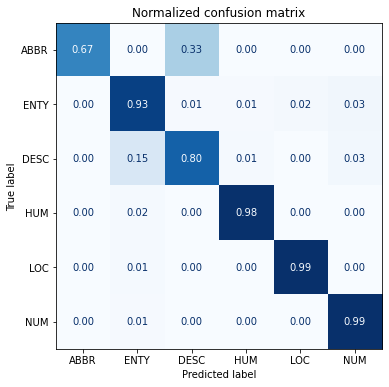

In [184]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(predictions, labels, label_names)

# Let's get the class weights for the dataset using sklearn's `compute_class_weight` API

In [185]:
# use the class_weights obtained using sklearn's compute_class_weight function
from sklearn.utils import class_weight
from collections import Counter
y = dataset["train"]['coarse_label']
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=np.asarray(y))
class_weights

array([42.53571429,  0.5955    ,  3.03826531,  0.60889571,  0.89146707,
        0.83054393])

In [186]:
class CustomTrainerWeighted(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).cuda(0).float()) # using gpu
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [187]:
modelWeighted = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

trainerWeighted = CustomTrainerWeighted(
    model=modelWeighted,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['dev'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=custom_compute_metrics,
)


In [188]:
trainerWeighted.train()

{'eval_loss': 0.3635643720626831, 'eval_precision': 0.7475485938860401, 'eval_recall': 0.7732515122531133, 'eval_f1': 0.75818463583422, 'eval_runtime': 1.0694, 'eval_samples_per_second': 835.96, 'eval_steps_per_second': 104.729, 'epoch': 0.99}
{'eval_loss': 0.3226809799671173, 'eval_precision': 0.7927437455013017, 'eval_recall': 0.8217658967778728, 'eval_f1': 0.805034678565571, 'eval_runtime': 1.0762, 'eval_samples_per_second': 830.7, 'eval_steps_per_second': 104.07, 'epoch': 1.99}
{'eval_loss': 0.40748149156570435, 'eval_precision': 0.8699273925750085, 'eval_recall': 0.8241602661738431, 'eval_f1': 0.8400026283545089, 'eval_runtime': 1.0911, 'eval_samples_per_second': 819.38, 'eval_steps_per_second': 102.652, 'epoch': 2.99}
{'eval_loss': 0.41149285435676575, 'eval_precision': 0.8374219736469534, 'eval_recall': 0.827102100211844, 'eval_f1': 0.8312235810245793, 'eval_runtime': 1.0288, 'eval_samples_per_second': 868.941, 'eval_steps_per_second': 108.861, 'epoch': 3.99}
{'loss': 0.2914, 'l

TrainOutput(global_step=555, training_loss=0.26340277339961077, metrics={'train_runtime': 94.9182, 'train_samples_per_second': 188.215, 'train_steps_per_second': 5.847, 'train_loss': 0.26340277339961077, 'epoch': 4.99})

Our best F1-score is 0.773 at 7th epoch, which is a bit more than the score(=0.769) obtained without class weighting.

In [189]:
predictions, labels, _ = trainerWeighted.predict(tokenized_dataset['test'])
predictions = np.argmax(predictions, axis = 1)
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.91      0.96      0.93        90
           2       0.96      0.96      0.96       138
           3       0.98      0.97      0.98        66
           4       1.00      0.96      0.98        84
           5       0.99      0.97      0.98       115

    accuracy                           0.97       500
   macro avg       0.94      0.97      0.95       500
weighted avg       0.97      0.97      0.97       500



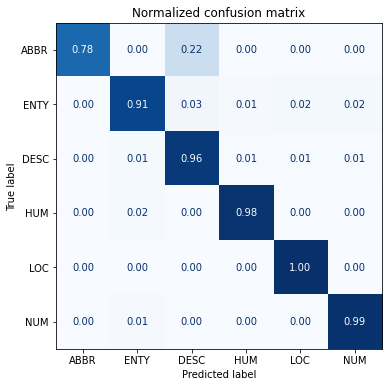

In [190]:
plot_confusion_matrix(predictions, labels, label_names)